# Microscopy Data File Structure Demo

This notebook demonstrates how to analyze and work with the microscopy image file structure across different plates.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage import io
import dask.dataframe as dd

# Import our utility functions
sys.path.append('..')
from notebooks.file_structure_utils import (
    analyze_plate_structure,
    get_image_path,
    get_available_channels,
    extract_cell_from_site,
    create_rgb_cell_image
)

## 1. Analyze Plate Structure

First, let's analyze the structure of all plates to understand which channels are available in each.

In [2]:
# Analyze the structure of all plates
plate_structure = analyze_plate_structure(base_dir='../data/ops', screen='screenA')
plate_structure

""


## 2. Load Metadata from Parquet File

In [4]:
# Load the metadata
data_dir = '../../njwfish/DistributionEmbeddings/data/ops'

df = dd.read_parquet(data_dir+'/interphase-reclassified_cp_phenotype_normalized.parquet', engine='pyarrow')

# Convert to pandas DataFrame (small sample)
df_sample = df.head(10_000)  # Just take 100 rows for testing
print(f"Sample data shape: {df_sample.shape}")

Sample data shape: (1994, 1131)


/orcd/home/002/gokulg/miniforge3/envs/distemb/lib/python3.11/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 1994 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [34]:
[c for c in df_sample.columns]

['plate',
 'tile',
 'well',
 'label',
 'cell_0',
 'i_0',
 'j_0',
 'site',
 'cell_1',
 'i_1',
 'j_1',
 'gene_symbol_0',
 'group_0',
 'bounds_0',
 'bounds_1',
 'bounds_2',
 'bounds_3',
 'class_predict_0',
 'class_predict_1',
 'nucleus_i',
 'nucleus_j',
 'nucleus_bounds_0',
 'nucleus_bounds_1',
 'nucleus_bounds_2',
 'nucleus_bounds_3',
 'cell_i',
 'cell_j',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'nucleus_dapi_int',
 'nucleus_tubulin_int',
 'nucleus_gh2ax_int',
 'nucleus_phalloidin_int',
 'nucleus_dapi_mean',
 'nucleus_tubulin_mean',
 'nucleus_gh2ax_mean',
 'nucleus_phalloidin_mean',
 'nucleus_dapi_std',
 'nucleus_tubulin_std',
 'nucleus_gh2ax_std',
 'nucleus_phalloidin_std',
 'nucleus_dapi_max',
 'nucleus_tubulin_max',
 'nucleus_gh2ax_max',
 'nucleus_phalloidin_max',
 'nucleus_dapi_min',
 'nucleus_tubulin_min',
 'nucleus_gh2ax_min',
 'nucleus_phalloidin_min',
 'nucleus_dapi_int_edge',
 'nucleus_tubulin_int_edge',
 'nucleus_gh2ax_int_edge',
 'nucleus_phall

In [35]:
# Look at key columns we'll need for extracting cells
key_columns = [
    'plate', 'well', 'site', 'tile',
    'cell_i', 'cell_j',
    'cell_bounds_0', 'cell_bounds_1', 'cell_bounds_2', 'cell_bounds_3'
]

df_sample[key_columns].head()

,plate,well,site,tile,cell_i,cell_j,cell_bounds_0,cell_bounds_1,cell_bounds_2,cell_bounds_3
sgRNA_0,,,,,,,,,,
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,A1,63,211,1309.245844,2721.277460,1255.0,2686.0,1376.0,2769.0
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,A1,60,267,2649.027950,2376.183905,2603.0,2312.0,2701.0,2423.0
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,A1,60,267,2679.913828,2462.622130,2636.0,2410.0,2742.0,2518.0
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,A1,60,267,2696.312098,2609.519645,2652.0,2574.0,2737.0,2653.0
AAAACAAAAGCAGATGACCG,20200202_6W-LaC024A,A1,60,268,232.826695,2604.449529,190.0,2554.0,293.0,2663.0


## 3. Check Available Channels for Sample Cells

In [36]:
# Check which channels are available for each sample
channel_results = []

for i, row in df_sample.iterrows():
    plate = row['plate']
    well = row['well']
    site = row['site']
    
    available_channels = get_available_channels(plate, well, site)
    
    channel_results.append({
        'plate': plate,
        'well': well,
        'site': site,
        'available_channels': ', '.join(available_channels)
    })

channel_df = pd.DataFrame(channel_results)
channel_df.groupby(['plate', 'available_channels']).size().reset_index(name='count')

,plate,available_channels,count
0,20200202_6W-LaC024A,"DAPI-GFP, A594, AF750",257
1,20200202_6W-LaC024B,,32
2,20200202_6W-LaC024B,"A594, AF750",259
3,20200202_6W-LaC024C,,39
4,20200202_6W-LaC024C,A594,10
5,20200202_6W-LaC024C,"A594, AF750",231
6,20200202_6W-LaC024D,,74
7,20200202_6W-LaC024D,"A594, AF750",5
8,20200202_6W-LaC024D,"DAPI-GFP, A594, AF750",116
9,20200202_6W-LaC024E,,124


## 4. Test Image Path Construction

In [37]:
# Test the image path construction function on a sample row
if len(df_sample) > 0:
    sample_row = df_sample.iloc[0]
    plate = sample_row['plate']
    well = sample_row['well']
    site = sample_row['site']
    
    print(f"Sample cell - Plate: {plate}, Well: {well}, Site: {site}")
    
    # Try constructing paths for different channels
    for channel in ['DAPI-GFP']:
        path = get_image_path(plate, well, site, channel)
        exists = path is not None and os.path.exists(path)
        print(f"Channel: {channel}, Path: {path}")
        print(f"File exists: {exists}\n")

Sample cell - Plate: 20200202_6W-LaC024A, Well: A1, Site: 63
Channel: DAPI-GFP, Path: ../data/ops/screenA/20200202_6W-LaC024A/phenotype/images/input/DAPI-GFP-A594-AF750/20X_DAPI-GFP-A594-AF750_A1_DAPI-GFP_Site-63.tif
File exists: True



## 5. Extract a Cell from an Image

In [39]:
len(df_sample)

1994

[1285, 2704, 1339, 2758]
Cell bounds: [1285, 2704, 1339, 2758]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 211
Cell bounds: [1285, 2704, 1339, 2758]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(54, 54, 4), (54, 54, 4), (54, 54, 4), (54, 54, 4)]


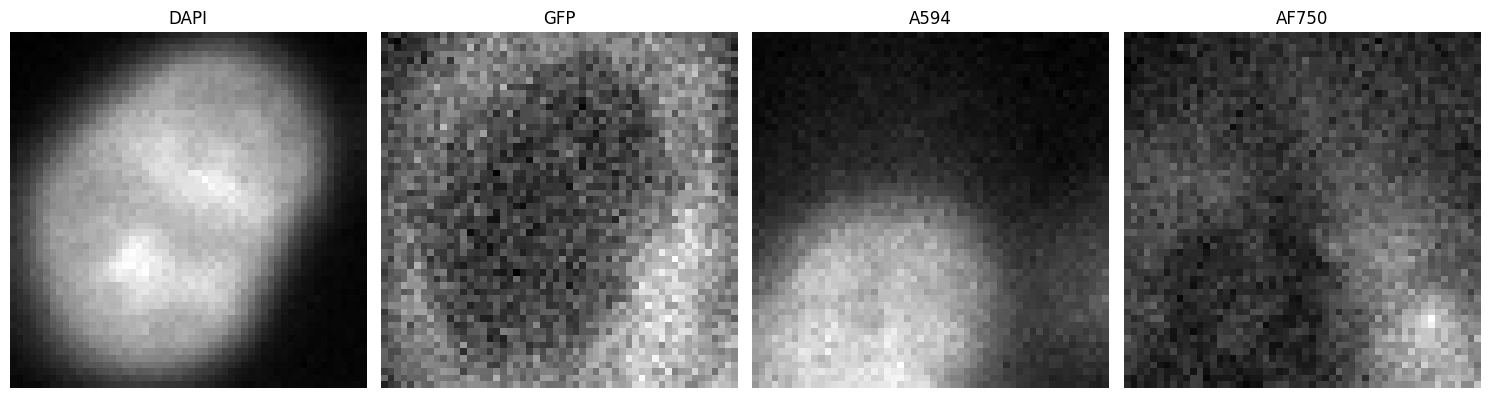

[2620, 2347, 2674, 2401]
Cell bounds: [2620, 2347, 2674, 2401]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 267
Cell bounds: [2620, 2347, 2674, 2401]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(54, 54, 4), (54, 54, 4), (54, 54, 4), (54, 54, 4)]


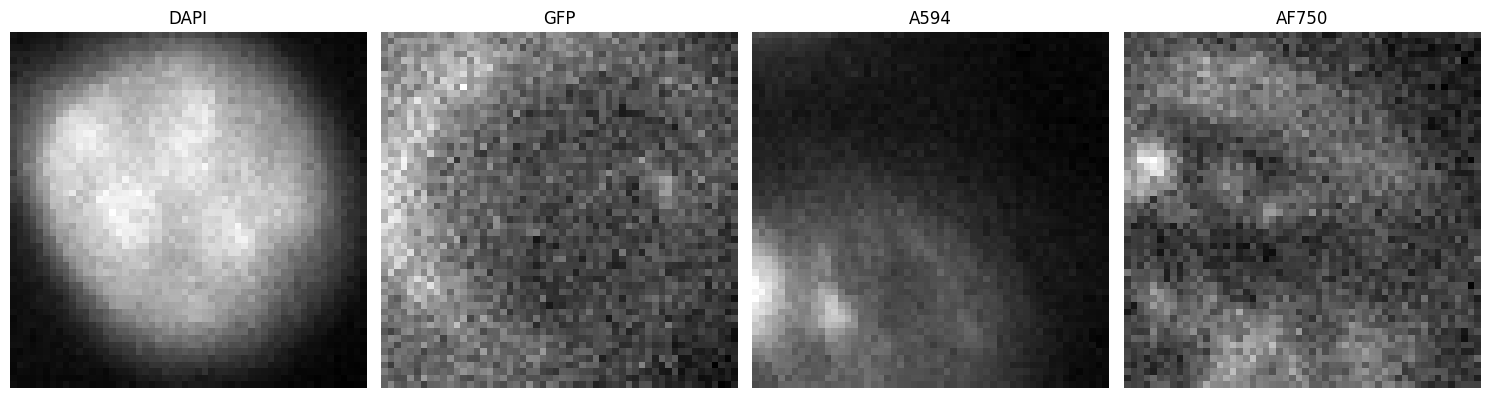

[2650, 2438, 2707, 2490]
Cell bounds: [2650, 2438, 2707, 2490]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 267
Cell bounds: [2650, 2438, 2707, 2490]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(57, 52, 4), (57, 52, 4), (57, 52, 4), (57, 52, 4)]


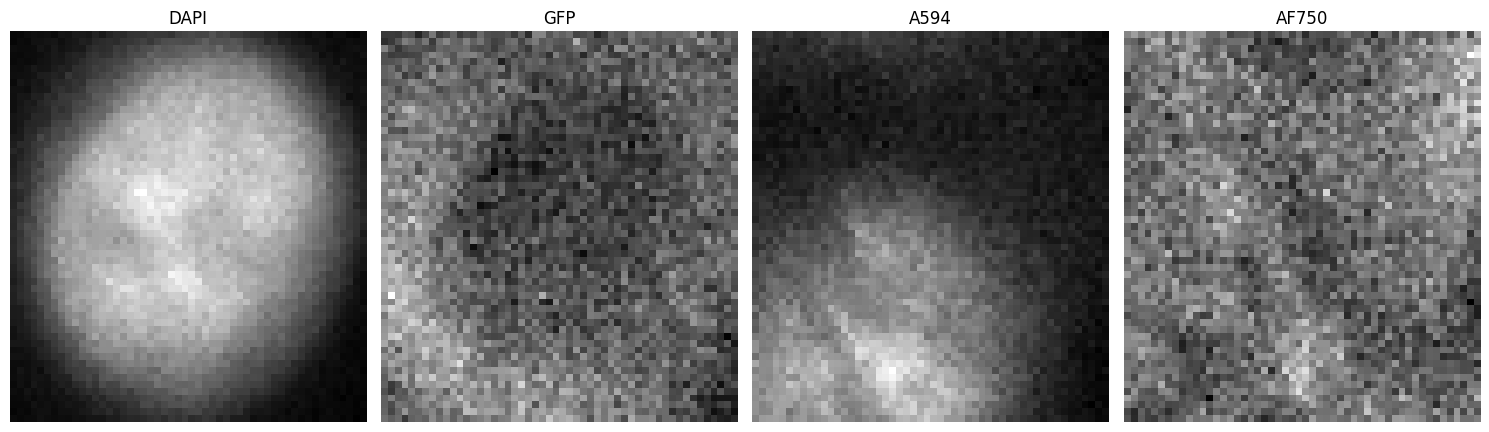

[2679, 2596, 2726, 2644]
Cell bounds: [2679, 2596, 2726, 2644]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 267
Cell bounds: [2679, 2596, 2726, 2644]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(47, 48, 4), (47, 48, 4), (47, 48, 4), (47, 48, 4)]


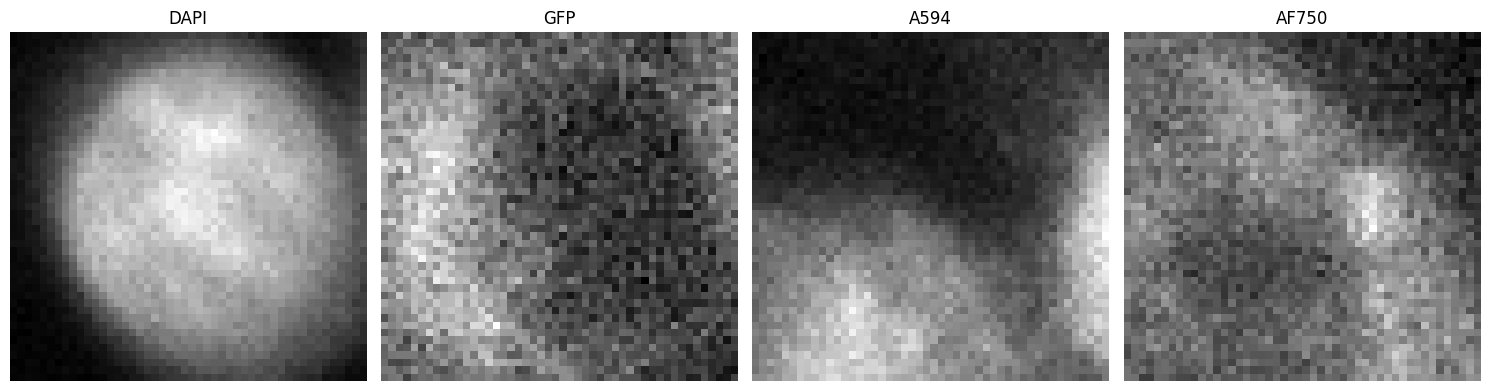

[201, 2588, 251, 2641]
Cell bounds: [201, 2588, 251, 2641]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 268
Cell bounds: [201, 2588, 251, 2641]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(50, 53, 4), (50, 53, 4), (50, 53, 4), (50, 53, 4)]


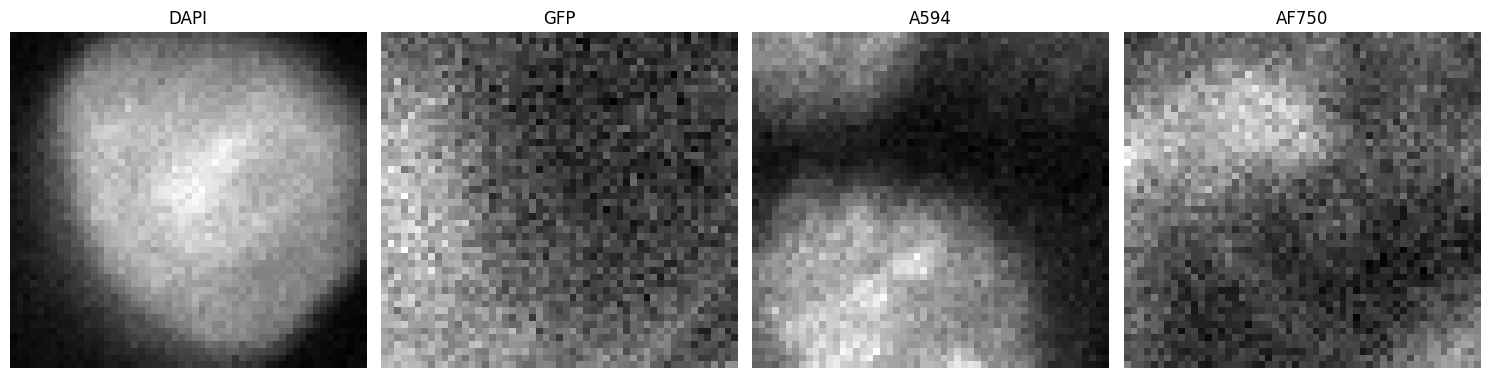

[905, 1909, 947, 1944]
Cell bounds: [905, 1909, 947, 1944]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 277
Cell bounds: [905, 1909, 947, 1944]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(42, 35, 4), (42, 35, 4), (42, 35, 4), (42, 35, 4)]


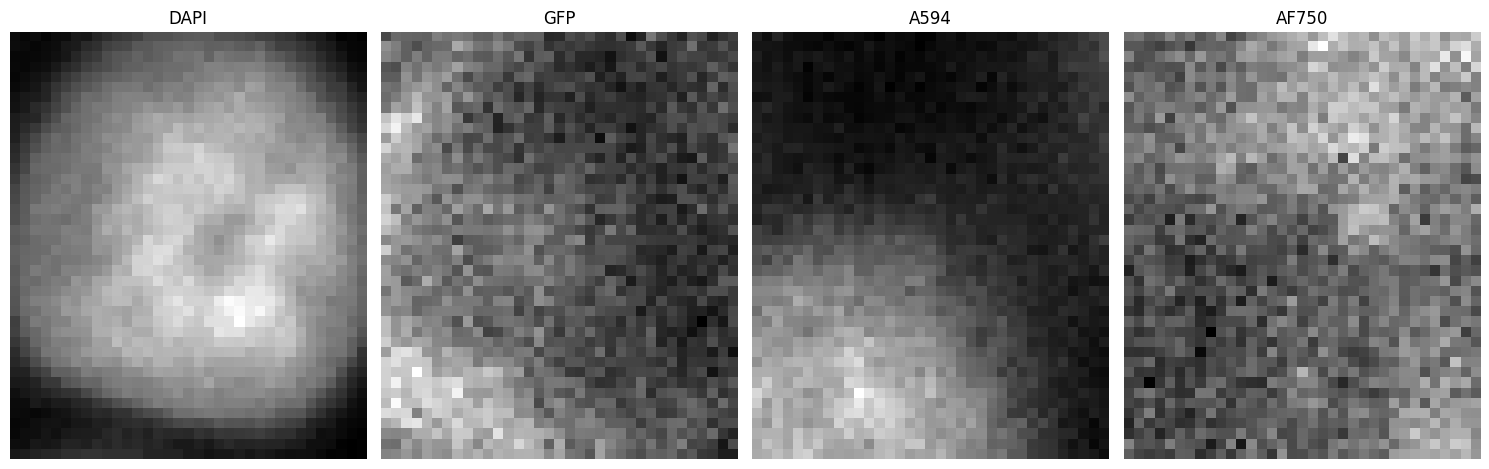

[901, 2000, 943, 2037]
Cell bounds: [901, 2000, 943, 2037]
Found cell with available channels: ['DAPI-GFP', 'A594', 'AF750']
Plate: 20200202_6W-LaC024A, Well: A1, Site: 277
Cell bounds: [901, 2000, 943, 2037]
Channel DAPI-GFP image shape: (4, 2, 2960, 2960)
Channel A594 image shape: (2960, 2960, 4)
Channel AF750 image shape: (2960, 2960, 4)
Cell images: [(42, 37, 4), (42, 37, 4), (42, 37, 4), (42, 37, 4)]


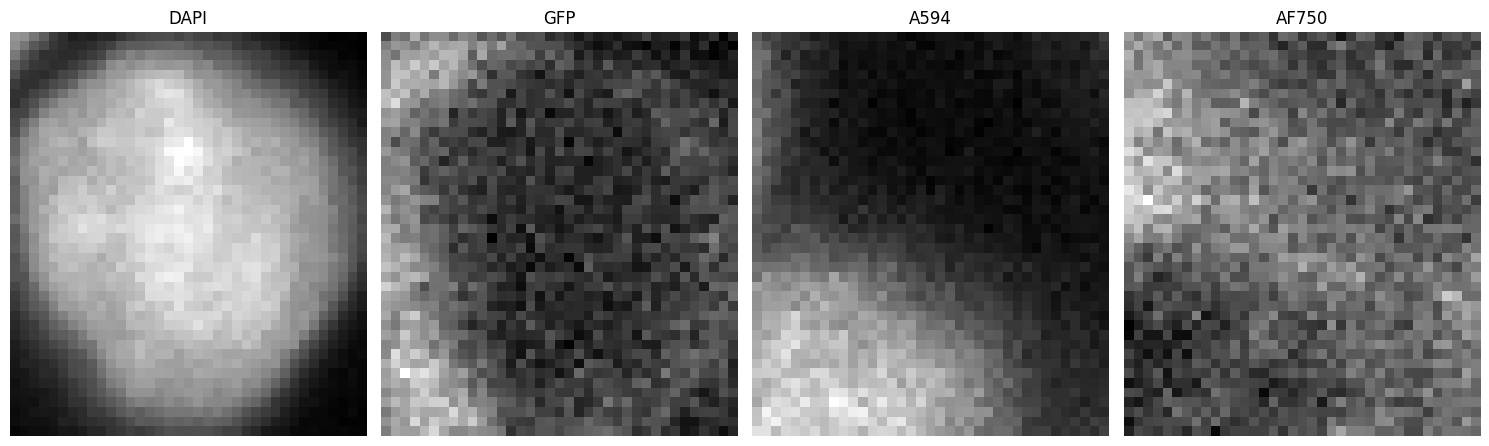

In [13]:
# Try extracting a cell image from a sample row
if len(df_sample) > 0:
    # Find a sample where we have channel information
    for i, (_, row) in enumerate(df_sample.iterrows()):
        plate = row['plate']
        well = row['well']
        # site = row['site']
        site = row['tile']

        cell_bounds = [
            row['bounds_0'], 
            row['bounds_1'], 
            row['bounds_2'], 
            row['bounds_3']
        ]
        
        # Check if channels are available
        available_channels = get_available_channels(plate, well, site, base_dir=data_dir)

        # cell_i = row['i_0'] - cell_bounds[0]
        # cell_j = row['j_0'] - cell_bounds[1]

        cell_bounds = [cell_bounds[0], cell_bounds[1], cell_bounds[2], cell_bounds[3]]
        print(cell_bounds)
        cell_i = row['j_0'] - cell_bounds[1]
        cell_j = row['i_0'] - cell_bounds[0]

        # cell_bounds = [0,0, 2960, 2960]
        # cell_i = 1480
        # cell_j = 1480

        print(f"Cell bounds: {cell_bounds}")

        if available_channels:
            print(f"Found cell with available channels: {available_channels}")
            print(f"Plate: {plate}, Well: {well}, Site: {site}")
            
            # Extract the cell
            # flip the cell bounds
            print(f"Cell bounds: {cell_bounds}")

            cell_images = extract_cell_from_site(plate, well, site, cell_bounds, pad=0, base_dir=data_dir)
            print(f"Cell images: {[cell_images.shape for cell_images in cell_images.values()]}")
            # transform row['cell_i'] row['cell_j'] to the image coordinates
            
            # Display the extracted images
            if cell_images:
                fig, axes = plt.subplots(1, len(cell_images), figsize=(15, 5))
                
                if len(cell_images) == 1:
                    axes = [axes]
                
                c = 1
                for ax, (channel, img) in zip(axes, cell_images.items()):

                    ax.imshow(img[:, :, c], cmap='gray')
                    # ax.scatter(cell_i, cell_j, color='red', s=100)
                    ax.set_title(f"{channel}")
                    ax.axis('off')

                # add row['cell_i'] row['cell_j'] a single point to the image
                
                
                plt.tight_layout()
                plt.show()
                
        if i > 5:
            break

In [ ]:
# Try extracting a cell image from a sample row
if len(df_sample) > 0:
    # Find a sample where we have channel information
    for i, (_, row) in enumerate(df_sample.iterrows()):
        plate = row['plate']
        well = row['well']
        site = row['site']
        cell_bounds = [
            row['bounds_0'], 
            row['bounds_1'], 
            row['bounds_2'], 
            row['bounds_3']
        ]
        
        # Check if channels are available
        available_channels = get_available_channels(plate, well, site)

        # cell_i = row['i_0'] - cell_bounds[0]
        # cell_j = row['j_0'] - cell_bounds[1]

        cell_bounds = [cell_bounds[1], cell_bounds[0], cell_bounds[3], cell_bounds[2]]
        cell_i = row['j_0'] - cell_bounds[0]
        cell_j = row['i_0'] - cell_bounds[1]

        cell_bounds = [0,0, 2960, 2960]
        # cell_i = 1480
        # cell_j = 1480

        print(f"Cell bounds: {cell_bounds}")

        if available_channels:
            print(f"Found cell with available channels: {available_channels}")
            print(f"Plate: {plate}, Well: {well}, Site: {site}")
            
            # Extract the cell
            # flip the cell bounds
            print(f"Cell bounds: {cell_bounds}")

            cell_images = extract_cell_from_site(plate, well, site, cell_bounds, pad=0)
            print(f"Cell images: {[cell_images.shape for cell_images in cell_images.values()]}")
            # transform row['cell_i'] row['cell_j'] to the image coordinates
            
            # Display the extracted images
            if cell_images:
                fig, axes = plt.subplots(1, len(cell_images), figsize=(15, 5))
                
                if len(cell_images) == 1:
                    axes = [axes]
                
                c = 1
                for ax, (channel, img) in zip(axes, cell_images.items()):

                    ax.imshow(img[:, :, c], cmap='gray')
                    # ax.scatter(cell_i, cell_j, color='red', s=100)
                    ax.set_title(f"{channel}")
                    ax.axis('off')

                # add row['cell_i'] row['cell_j'] a single point to the image
                
                
                plt.tight_layout()
                plt.show()
                
        if i > 5:
            break

## 6. Compare Cell Images Across Different Plates

In [ ]:
df_larger = df.head(100_000)

/home/njwfish/miniconda3/envs/cell-types/lib/python3.10/site-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 100000 elements requested, only 1994 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [ ]:
# Load more data to get samples from different plates
#   # Sample 1% of the data

# Group by plate
plate_groups = df_larger.groupby('plate')

# Try to get one sample from each plate
plate_samples = []

for plate, group in plate_groups:
    # Just take the first row from each plate
    plate_samples.append(group.iloc[0])

print(f"Found {len(plate_samples)} plate samples")

Found 8 plate samples



Plate: 20200202_6W-LaC024A
Available channels: ['DAPI-GFP', 'A594', 'AF750']


TypeError: Invalid shape (0, 0, 2960, 2960) for image data

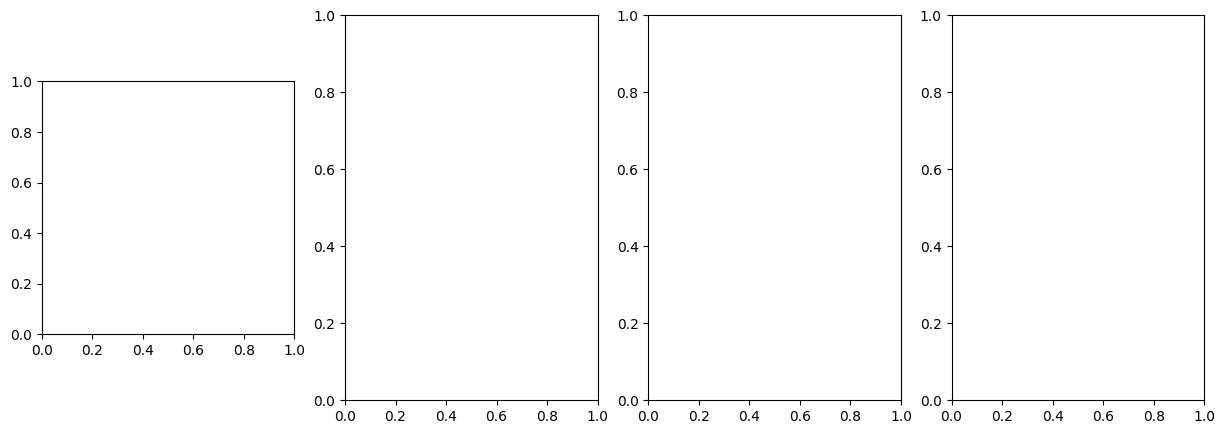

In [14]:
# Extract one cell from each plate to compare
for i, row in enumerate(plate_samples[:3]):  # Just try the first 3 plates
    plate = row['plate']
    well = row['well']
    site = row['site']
    cell_bounds = [
        row['cell_bounds_0'], 
        row['cell_bounds_1'], 
        row['cell_bounds_2'], 
        row['cell_bounds_3']
    ]
    
    # Check available channels
    available_channels = get_available_channels(plate, well, site)
    
    print(f"\nPlate: {plate}")
    print(f"Available channels: {available_channels}")
    
    if available_channels:
        # Extract the cell
        cell_images = extract_cell_from_site(plate, well, site, cell_bounds)
        
        if cell_images:
            # Display channels
            fig, axes = plt.subplots(1, len(cell_images), figsize=(15, 5))
            
            if len(cell_images) == 1:
                axes = [axes]
            
            for ax, (channel, img) in zip(axes, cell_images.items()):
                ax.imshow(img, cmap='gray')
                ax.set_title(f"{plate}\n{channel}")
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()

## Conclusion

You've now seen how to:

1. Analyze the file structure of the microscopy data across different plates
2. Determine which channels are available for a given cell
3. Extract cell images correctly from any plate regardless of its channel structure
4. Create composite RGB images from different channels

You can use these functions in your cell extraction workflow to handle the variations in file structure across plates.